In [1]:
import os
import pandas as pd
import numpy as np

## Часть 1. Что такое нейронная сеть



$X = (x_1, x_2, \ldots, x_n)$ — входные данные
    
$Y = (f(x_1), f(x_2), \ldots, f(x_n))$ — ground truth, наблюдаемые ответы, где f — целевая зависимость, ее значения известны нам на множестве входных данных.
    
Мы хотим найти  аппроксимацию $f$, назовем ее $\hat{f}$ используя обучащие данные $X' \subset X$, такие что
    
 $ \hat{f}(X') \sim f(X') \text{ and } \hat{f}(X'') \sim f(X''),$
где $X'' = X\setminus X' $ - тестовые данные


Допустим, мы задали функцию $\hat{f}(x_i)$ (построили нейросеть). Как нам оценить, насколько наша функция близка к исходной?
Для этого мы зададим функцию потерь = $ \textbf{loss/ cost function}$ $\mathcal{L}(f, \hat{f}, x)$ .
Будем усреднять значение функции потерь для множества семплов (в общем случае для всего обучающего множества):
    $$\mathcal{C} = \frac{1}{t}\sum_{i = 1}^{t} \mathcal{L}(f, \hat{f}, x_i), x_i \in X'.$$

Примеры функции потерь:
* **Кросс-энтропия** (записана для случая бинарной классификации):
$ \mathcal{L}(f,\hat{f}, x) = -(f(x)\cdot\log \hat{f}(x) + (1-f(x))\cdot\log(1-\hat{f}(x)));$


* **Квадратичное отклонение**:
$\mathcal{L}(f,\hat{f}, x) = (f(x) - \hat{f}(x))^2.$

Мы интерпретируем выход нейронной сети, как вероятность.  Допустим, мы предсказываем род существительных на данных русского языка. Наши классы _средний, мужской, женский_ . Допустим:
$$f(x)  = [0.0, 1.0, 0.0], \hat{f}(x) = [0.1, 0.56, 0.34];$$
Тогда, используя кросс-энтропию(обобщенную на случай много классовой классификации), получаем значение ошибки:
$$\mathcal{L} = -(0.0\cdot\log(0.1)+1.0\cdot\log(0.56)+0.0\cdot\log(0.34)) \approx 0.252$$

После вычисления значения функции потерь $ \mathcal{L}(f,\hat{f)}$  мы оптимизируем параметры нашей сети $\hat{f}(x_i)$ . Для этого нам понадобится понятие __градиентного спуска__.  

**Градиент** в математическом анализе — это вектор, указывающий на направление максимального роста функции в заданной точке. Вектор-градиент состоит из частных производных функции от каждого из ее параметров. 
$ \mathcal{L}(f,\hat{f)}$ зависит от множества параметров  нейронной сети, каждый из возможных наборов значений параметров соответствует точке в пространстве параметров, принадлежащей функции потерь. Если, находясь в данной точке, мы знаем, в каком направлении надо двигаться, чтобы функция возрастала быстрее всего, то, двигаясь в противоположном направлении, мы добьемся минимализации ее значений.

Как может быть устроена функция $\hat{f}(x_i)$? Нейросеть удобно изображать в виде  графа. Посмотрим, чему соответствуют его вершины и ребра

<img src='img/1_neuron.png' width='350' height='220' align='left'>

Вход в первый нейрон:
$z_1^1 = \theta^1_{11}\cdot x_{i1}+\theta^1_{12}\cdot x_{i2}+\theta^1_{13}\cdot x_{i3}+\theta^1_{14}\cdot x_{i4}+b^1_1.$

<img src='img/sigmoid.png' width='350' height='220' align='left'>

Сигмоида - одна из нелинейностей  (функций активации), применяющихся в нейронных сетях. Она принимает в себя выход с  одного из нейронов
$\sigma(x) = \frac{1}{1+e^{-x}}.$

<img src='img/2_layer.png' width='350' height='220' align='left'>

$a_i = \sigma(z^1_i)$

Тогда вход в $\hat{y}_1$:

$z_1^2 = \theta^2_{11}\cdot a_1 + \theta^2_{12}\cdot a_2 + \theta^2_{13}\cdot a_3 + \theta^2_{14}\cdot a_4+ \theta^2_{15}\cdot a_5+b^2_1,$

<img src='img/full.png' width='350' height='220' align='left'>

Более формально нейронную сеть можно представить в виде графа вычислений:

<img src='img/forward_backward.png' width='850' height='100' align='left'>

## Что еще почитать

1. [Нейронные сети для начинающих. Часть 1](https://habr.com/ru/post/312450/)
2. [Нейронные сети для начинающих. Часть 2](https://habr.com/ru/post/313216/)
3. [Machine Learning for Beginners: An Introduction to Neural Networks](https://towardsdatascience.com/machine-learning-for-beginners-an-introduction-to-neural-networks-d49f22d238f9)
4. A Beginner’s Guide to Neural Networks: [часть 1](https://towardsdatascience.com/a-beginners-guide-to-neural-networks-b6be0d442fa4) и [часть 2](https://towardsdatascience.com/a-beginners-guide-to-neural-networks-part-two-bd503514c71a).
5. [Tensorflow Playground](http://playground.tensorflow.org/)

## Часть 2. Пишем свою нейронную сеть

Построим нейросеть с одним полносвязным скрытым слоем, которая будет брать на вход сэмпл, представленный в виде признаков, а на выходе отдавать вероятность класса. Мы рассмотрим случай бинарной классификации, поэтому в выходном слое нам будет достаточно одного нейрона

Загружаем данные. Классический датасет содержит информацию о длине и ширине лепестка и чашелистика для трех видов ирисов

In [4]:
iris = pd.read_csv('data/iris.csv')

In [5]:
iris[:5]

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Для нашей тренировочной задачи упростим данные, оставив только два класса: __Virginica__ — 0 и __Versicolor__ — 1. Будем решать задачу бинарной классификации, классифицируя каждый семпл по двум признакам (длина и ширина лепестка)

In [14]:
iris.loc[iris['species']=='Iris-virginica','species_num']=0
iris.loc[iris['species']=='Iris-versicolor','species_num']=1
iris.loc[iris['species']=='Iris-setosa','species_num'] = 2
iris = iris[iris['species_num']!=2]

In [15]:
X = iris[['petal_length', 'petal_width']].values.T #(2,100)
Y = iris[['species_num']].values.T #(1,100)

Визуализируем наши данные в двумерном пространстве признаков, разные цвета соответствуют разным классам

In [13]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

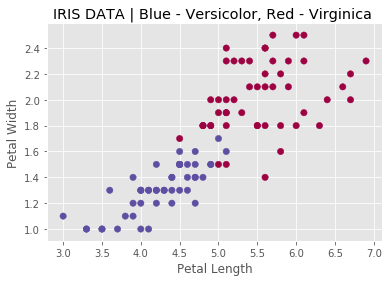

In [16]:
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);
plt.title("IRIS DATA | Blue - Versicolor, Red - Virginica ")
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

### Инициализация весов 
Напишем нейросеть прямого распространения с одним скрытым слоем.

**Bias vector** — выход для нулевого входа (т.е. сеть должна уметь передавать на следующий слой не 0, даже если на вход поступил 0).  

In [30]:
# Функция для инициализации параметров

def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h, n_x) * 0.01   # матрица весов размера (n_h, n_x)
    b1 = np.zeros(shape=(n_h, 1))           # bias vector размера (n_h, 1)
    W2 = np.random.randn(n_y, n_h) * 0.01   # матрица весов размера (n_y, n_h)
    b2 = np.zeros(shape=(n_y, 1))           # bias vector размера (n_y, 1)
       
    #словарь параметров    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
def layer_sizes(X, Y):
    n_x = X.shape[0] 
    n_h = 6
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

### Прямой шаг

Шаг вперед, пропускаем входную последовательность через нейроны сети, запоминая выходы с промежуточных шагов. A2 — полученное предсказание

In [31]:
def forward_propagation(X, parameters):

# достаем параметры из словаря 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
# Делаем прямой шаг и рассчитываем вероятность (А2)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)         # функция активации tanh
    Z2 = np.dot(W2, A1) + b2
    A2 = 1/(1+np.exp(-Z2))   # функция активации sigmoid
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

### Функция ошибки
Насколько мы далеки от правильных ответов? Функция потерь сравнивает предсказания A2 c реальными результатами Y и возвращает оценку ошибки.

В качестве функции ошибки, которую нужно будет минимизировать, возьмем кросс-энтропию.

In [32]:
def compute_cost(A2, Y, parameters):
   
    m = Y.shape[1] # количество примеров
    
    # W1 и W2 из словаря параметров
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Считаем кросс-энтропию
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    return cost

### Обратный шаг

Шаг назад: обратное распространение ошибки. Хотим получить вектор градиента, состоящий из частных производных по всем из параметров. Вектор указывает направление, в котором функция потерь растет быстрее всего

In [21]:
def backward_propagation(parameters, cache, X, Y):

    # количество примеров
    m = X.shape[1]

    # параметры из словаря 
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # достаем A1 и A2 из кэша
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Обратный шаг: считаем dW1, db1, dW2, db2. 
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1)
    
    # градиенты
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

Наша задача — минимизация функции потерь, поэтому мы идем в противоположном градиенту напривлении. Длина шага — **learning rate**. Сохраняем обновленные веса. С ними наша сеть будет предсказывать чуть лучше

In [22]:
def update_parameters(parameters, grads, learning_rate=1.2):
   # Достаем параметры (=веса)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Достаем градиенты
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Обновляем веса
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Собираем нейросеть

Собираем все шаги в единую сеть, где процесс обучения выполняется циклом длиной в количество эпох:


*  **Forward propagation**: делаем шаг вперед, пропуская входные данные через нейроны сети.
*  Cчитаем значение **функции ошибки** *(cost/loss function)*.
*  **Back propagation**: ищем градиент — направление максимального роста cost function при нынешних параметрах. 
*  **Обновляем веса**, перемещаясь по функции потерь в обратном градиенту направлении.



In [23]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Инициализируем параметры, достаем W1, b1, W2, b2
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Градиентный спуск
    for i in range(0, num_iterations):
         
        # Шаг вперед. Вход: "X, parameters". Выход: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Функция потерь. Вход: "A2, Y, parameters". Выход: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Обратный шаг. Вход: "parameters, cache, X, Y". Выход: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Обновляем веса. Вход: "parameters, grads". Выход: "parameters".
        parameters = update_parameters(parameters, grads)
                
        # Печатаем значение функции ошибок на каждой 1000 итерации
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    return parameters

Обучим модель за 1000 итераций и за 50000 итераций, в обоих случаях сохраним параметры



In [24]:
parameters_1000 = nn_model(X,Y , n_h = 6, num_iterations = 1000, print_cost=False)
parameters_50000 = nn_model(X,Y , n_h = 6, num_iterations = 50000, print_cost=True)

Cost after iteration 0: 0.693225
Cost after iteration 1000: 0.402530
Cost after iteration 2000: 0.149060
Cost after iteration 3000: 0.132325
Cost after iteration 4000: 0.132567
Cost after iteration 5000: 0.115366
Cost after iteration 6000: 0.099302
Cost after iteration 7000: 0.097014
Cost after iteration 8000: 0.095698
Cost after iteration 9000: 0.094169
Cost after iteration 10000: 0.092606
Cost after iteration 11000: 0.102696
Cost after iteration 12000: 0.084246
Cost after iteration 13000: 0.086917
Cost after iteration 14000: 0.101385
Cost after iteration 15000: 0.089592
Cost after iteration 16000: 0.153410
Cost after iteration 17000: 0.078748
Cost after iteration 18000: 0.100950
Cost after iteration 19000: 0.074750
Cost after iteration 20000: 0.085039
Cost after iteration 21000: 0.074722
Cost after iteration 22000: 0.077477
Cost after iteration 23000: 0.080326
Cost after iteration 24000: 0.064107
Cost after iteration 25000: 0.082830
Cost after iteration 26000: 0.079070
Cost after ite

In [0]:
parameters_1000

{'W1': array([[-0.73141044, -2.89369836],
        [ 0.56087706, -4.57804212],
        [-0.61413975, -1.13668055],
        [-0.21459578,  3.66758731],
        [ 1.04207635, -8.36993525],
        [-0.09082063,  6.15140858]]),
 'W2': array([[ 0.18639226,  0.7308664 , -0.03472296, -0.27995301,  0.90962261,
         -0.73329316]]),
 'b1': array([[ 2.55350781],
        [ 6.71412659],
        [ 0.91551246],
        [-5.33323044],
        [10.35471932],
        [-8.37471096]]),
 'b2': array([[0.7122717]])}

Посмотрим на результаты для двух наборов параметров. Для этого просто сделаем forward_propagation.

In [25]:
preds_1000 = forward_propagation(X, parameters_1000)
preds_1000 = preds_1000[0]

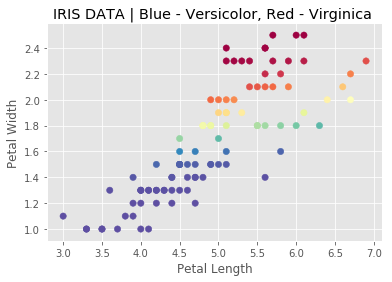

In [27]:
plt.scatter(X[0, :], X[1, :], c=preds_1000[0,:], s=40, cmap=plt.cm.Spectral);
plt.title("IRIS DATA | Blue - Versicolor, Red - Virginica ")
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()


In [26]:
preds_50000 = forward_propagation(X, parameters_50000)
preds_50000 = preds_50000[0]

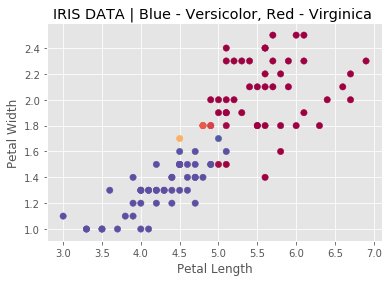

In [28]:
plt.scatter(X[0, :], X[1, :], c=preds_50000[0,:], s=40, cmap=plt.cm.Spectral);
plt.title("IRIS DATA | Blue - Versicolor, Red - Virginica ")
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

## Задание

Попробуем с помощью той же самой сети решить задачу классификации для классического датасета 20 newsgroups. Классы в виде чисел лежат в атрибуте target, а имена классов – в target_names.

In [29]:
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
from pprint import pprint
import numpy as np
import pandas as pd

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
pprint(newsgroups_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Для упрощения задачи оставим любые два класса.

In [0]:
categories = ['', '']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

In [0]:
newsgroups_train.['target'][:10]

### Подготовка данных

Обучающие данные *(X_train)* необходимо векторизовать, а после превратить получившуюся разреженную матрицу *(sparse matrix)* с множеством нулей в плотную матрицу *(dense matrix)*. Столбец с класcами *(Y_train)* нужно преобразовать в матрицу и затем транспонировать ее.  То же самое нужно проделать с тестовыми данными.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()

# YOUR CODE HERE 

### Обучение

Необходимо добавить значения параметров. При желании можно использовать `grid search` для подбора параметров (размер скрытого слоя, количество итераций).

In [0]:
parameters = nn_model(X, Y , n_h =, num_iterations=, print_cost=)

### Тестирование

На данном шаге нужно посмотреть предсказания сети на тестовых данных. Не забудьте их векторизовать!

In [0]:
# YOUR CODE HERE

# здесь тестовые данные и сохраненные на предыдущем шаге параметры
preds = forward_propagation() 

Оценим качетсво сети по основным метрикам (точность, полнота, f-мера, accuracy) и построим матрицу ошибок.  

В нашем случае предсказания — это вероятность класса 1. Чтобы получить `classification_report`, нужно добавить в архитектуру сети функцию, которая по вероятности будет выдавать класс, или же обработать полученные предсказания соответствующим образом.

In [0]:
# YOUR CODE HERE

print(metrics.classification_report()) # реальные классы и предсказания

In [0]:
import seaborn as sns

m = confusion_matrix() # реальные классы и предсказания

plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, cmap=plt.cm.Spectral)
plt.title("")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Также оценим качество с помощью AUC-ROC — популярной метрики для бинарной классификации. 

**ROC-кривая** (англ. *receiver operating characteristic*, рабочая характеристика приёмника) — график, позволяющий оценить качество бинарной классификации. Он отображает соотношение  *true positive rate, (TPR)* и  *false positive rate (FPR)* при варьировании порога решающего правила. 


Количественную интерпретацию ROC даёт показатель **AUC** (англ. *area under ROC curve*, площадь под ROC-кривой) — площадь, ограниченная ROC-кривой и осью доли FP. Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). 

In [0]:
fpr, tpr, threshold = metrics.roc_curve() # реальные классы и предсказания
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--') # внешний вид можно изменить по своему вкусу
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()